# Depth of snow cover in Kaisaniemi Helsinki

This notebook investigates the depth of snow in Kaisaniemi Helsinki over last 60 years. Especially we look in to the probability of snow depth being more than 0 cm on a single day each year.



The data is originally from FMI: https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

In [1]:

library("readr") # For reading data files
library("dplyr") # de-facto library for data preprosessing
library("ggplot2") # de-facto library for visualization



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
library("rstan") # observe startup messages
library("bayesplot")

Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
This is bayesplot version 1.7.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting


In [3]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
#options(repr.plot.width  = 6, repr.plot.height = 4) # Tune plot sizes

In [4]:
# Load and cleanup data
# ovewrite original column names
# parse dates from several columns
# clean up negative snow depths
d <-  read_csv("https://raw.githubusercontent.com/dins/snow-depth/master/kaisaniemi.csv", 
               col_types = cols(`Lumensyvyys (cm)` = col_character())) %>%
      setNames(c("year", "month", "day", "clock", "tzone", "snow", "temp")) %>%
      mutate(date = ISOdate(year, month, day), 
             snow = ifelse(snow==FALSE, 0, as.numeric(snow)), 
             snow = ifelse(snow < 0, 0, snow), 
             is_snow = snow > 0) %>%
      select(date, year, month, day, snow, is_snow, temp)
saveRDS(d, file="kaisaniemi_daily.rds")

In [5]:
glimpse(d)

Observations: 50,361
Variables: 7
$ date    <dttm> 1882-01-01 12:00:00, 1882-01-02 12:00:00, 1882-01-03 12:00:0…
$ year    <dbl> 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1…
$ month   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ day     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…
$ snow    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ is_snow <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ temp    <dbl> -2.6, -0.6, 1.8, 2.7, 0.4, 1.1, 2.6, -0.8, -2.3, 0.6, 1.2, -6…


In [6]:
# Look into a specific day of the year
# Remove years with out snow depth measurement
christmas <- d %>% filter(!is.na(snow))%>% filter(day==24 & month==12)
readr::write_csv(christmas, "kaisaniemi_christmas.csv")

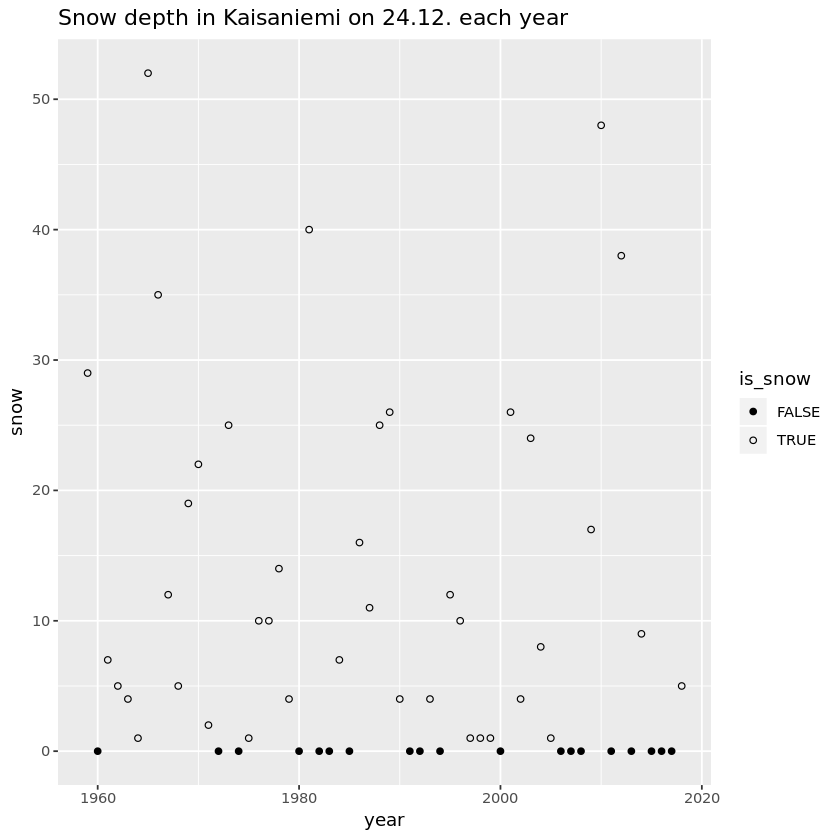

In [7]:
ggplot(christmas, aes(x=year, y=snow)) + 
  geom_point(aes(shape=is_snow)) + 
  scale_shape_manual(values=c(19, 1)) + 
  #geom_smooth(method="lm") + 
  labs(title = "Snow depth in Kaisaniemi on 24.12. each year")

In [7]:
stan_data <- with(christmas, list(decade=(year-2000)/10, is_snow=is_snow, N=length(is_snow)))


In [10]:
first_model_code <- "
data {
   int N;
   int<lower=0, upper=1> is_snow[N]; }
parameters {
   real b; }
model {
   for (i in 1:N) is_snow[i] ~ bernoulli_logit(b); }
"

In [12]:
m0 <- stan_model(model_code = first_model_code)
fit0 <- sampling(m0, data=stan_data)
fit0

Inference for Stan model: e65371ca4377d3f2a0a5223817d35934.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b      0.80    0.01 0.28   0.26   0.61   0.80   0.99   1.37  1466    1
lp__ -37.97    0.02 0.72 -40.02 -38.12 -37.69 -37.51 -37.46  2142    1

Samples were drawn using NUTS(diag_e) at Mon Dec  9 13:27:54 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

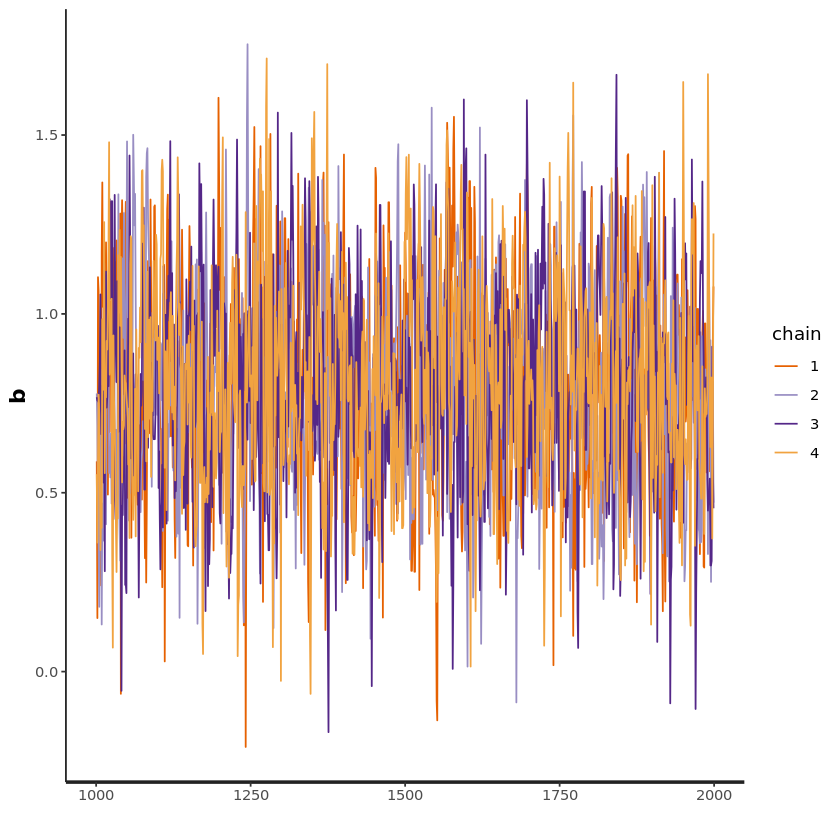

In [13]:
traceplot(fit0)

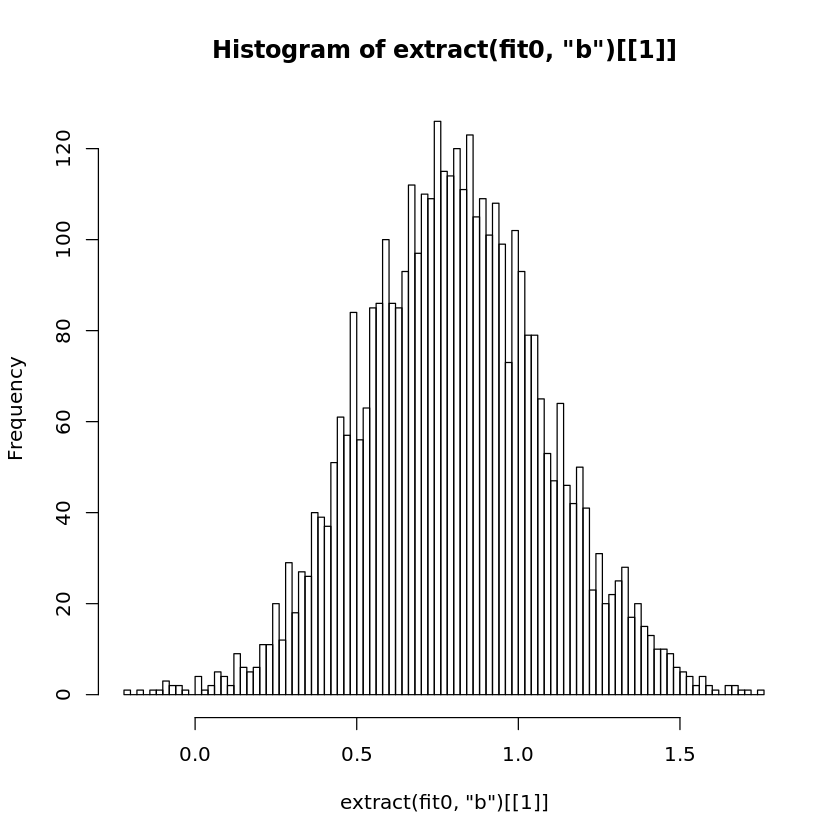

In [15]:
hist(extract(fit0, "b")[[1]], n=100)

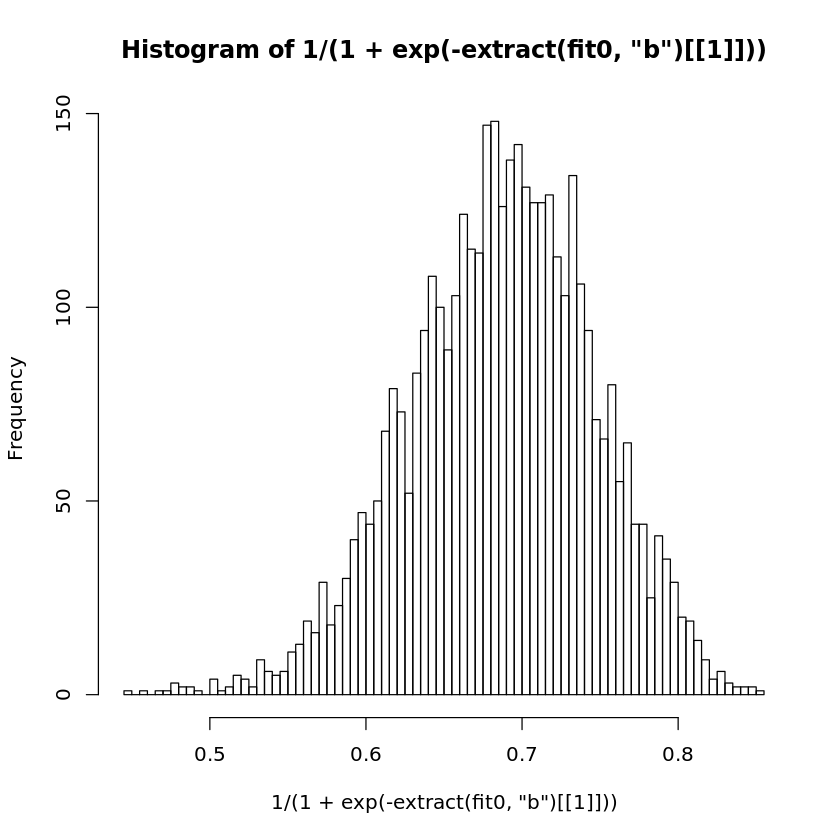

In [17]:
hist(1/(1+exp(-extract(fit0, "b")[[1]])), n=100)

In [9]:
logistic_reggr_code <- "
data {
   int N;
   int<lower=0, upper=1> is_snow[N];
   real decade[N]; 
}
parameters {
   real b;
   real k; 
}
model {
   for (i in 1:N) is_snow[i] ~ bernoulli_logit(k * decade[i] + b); 
}
generated quantities {
   real prob[N];
   for (i in 1:N) prob[i] = inv_logit(k* decade[i] + b);
}
"

In [10]:
m <- stan_model(model_code = logistic_reggr_code)
fit <- sampling(m, data=stan_data)
fit


Inference for Stan model: 34953b98adb6671f2cdcb0ae4c96ad4f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b          0.45    0.01 0.32  -0.17   0.23   0.45   0.67   1.07  1826    1
k         -0.36    0.00 0.17  -0.71  -0.48  -0.36  -0.25  -0.03  1861    1
prob[1]    0.86    0.00 0.08   0.68   0.81   0.87   0.91   0.96  2914    1
prob[2]    0.85    0.00 0.07   0.68   0.81   0.87   0.91   0.96  2945    1
prob[3]    0.85    0.00 0.07   0.68   0.81   0.86   0.91   0.96  2978    1
prob[4]    0.85    0.00 0.07   0.67   0.80   0.86   0.90   0.95  3013    1
prob[5]    0.84    0.00 0.07   0.67   0.80   0.85   0.90   0.95  3050    1
prob[6]    0.84    0.00 0.07   0.67   0.79   0.85   0.89   0.95  3089    1
prob[7]    0.83    0.00 0.07   0.67   0.79   0.84   0.89   0.94  3130    1
prob[8]    0.83    0.00 0.07   0.66   0.79   0.84   0.88   0.94  3174   

'pars' not specified. Showing first 10 parameters by default.


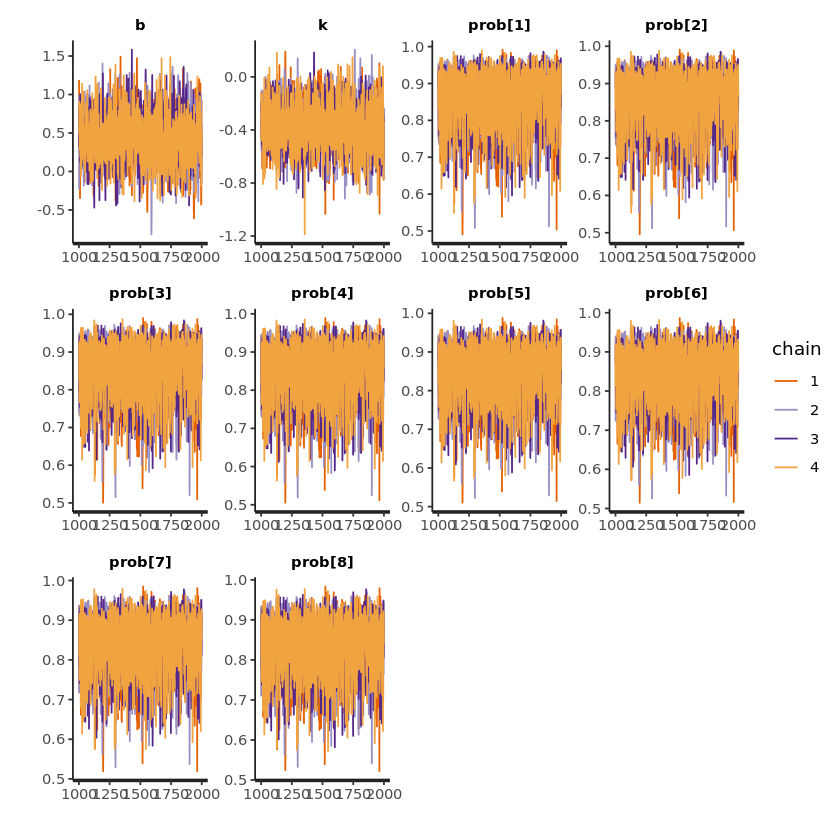

In [11]:
traceplot(fit)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


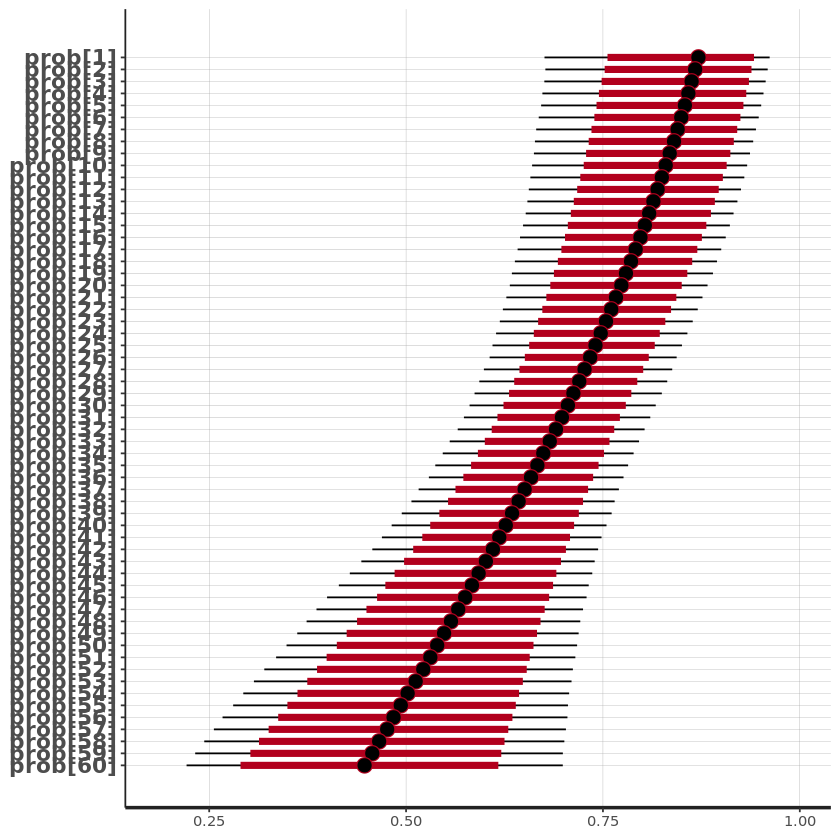

In [12]:
#plot(fit, pars=c("k", "b"))
plot(fit, pars="prob")

In [13]:
# Has snow cover decreased significantly?
diff_samples <- extract(fit, "prob[1]")[[1]] - extract(fit, "prob[60]")[[1]]
# probability of decrease
mean(diff_samples > 0)

[1] 0.98475

In [14]:
# Now estimate snow propability for 2019
decade_2019 <- (2019 - 2000) / 10
post_draws <- extract(fit)
library(boot)
predictions <- inv.logit(post_draws$b + post_draws$k * decade_2019)

In [15]:
mean(predictions)

[1] 0.4437161

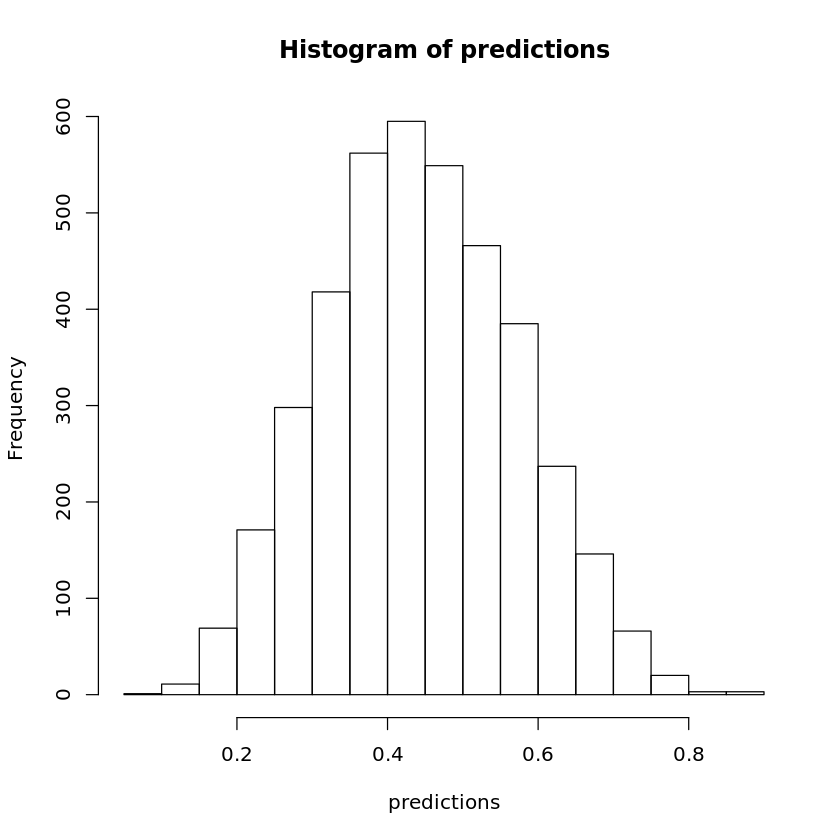

In [16]:
hist(predictions)

In [11]:
statespace_code <- "
data {
   int N;
   int<lower=0, upper=1> is_snow[N]; }
parameters {
   vector[N] innovations;
   real base;
   real<lower=0> sigma;
   real ytrend;
   }
model {
   innovations ~ normal(ytrend, 1);
   is_snow ~ bernoulli_logit(base + sigma * cumulative_sum(innovations));
   base ~ normal(0, 5);
   sigma ~ normal(0, .1);
   ytrend ~ normal(0, .1);
}
generated quantities {
   vector[N] prob;
   prob = inv_logit(base + sigma * cumulative_sum(innovations));
}
"

mss <- stan_model(model_code = statespace_code)
fit_ss <- sampling(mss, data=stan_data, control=list(adapt_delta=.95))


In [12]:
fit_ss

Inference for Stan model: d07415adc75784c3ea44187288e199d7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
innovations[1]   -0.04    0.01 0.99  -2.01  -0.69  -0.03   0.63   1.91  6268
innovations[2]   -0.07    0.01 0.98  -1.97  -0.73  -0.08   0.59   1.90  5804
innovations[3]    0.00    0.01 0.99  -1.98  -0.65   0.00   0.68   1.88  6462
innovations[4]   -0.03    0.01 1.03  -2.08  -0.74  -0.03   0.67   1.97  6630
innovations[5]   -0.03    0.01 1.00  -1.98  -0.71  -0.02   0.66   1.89  6172
innovations[6]   -0.02    0.01 1.02  -2.04  -0.73  -0.01   0.66   1.96  6727
innovations[7]   -0.06    0.01 0.99  -2.01  -0.71  -0.04   0.62   1.85  6626
innovations[8]   -0.10    0.01 0.97  -1.97  -0.76  -0.10   0.56   1.77  5617
innovations[9]   -0.13    0.01 0.99  -2.05  -0.82  -0.12   0.53   1.86  6152
innovations[10]  -0.14    0.01 1.01  -2.11  -0.85  -

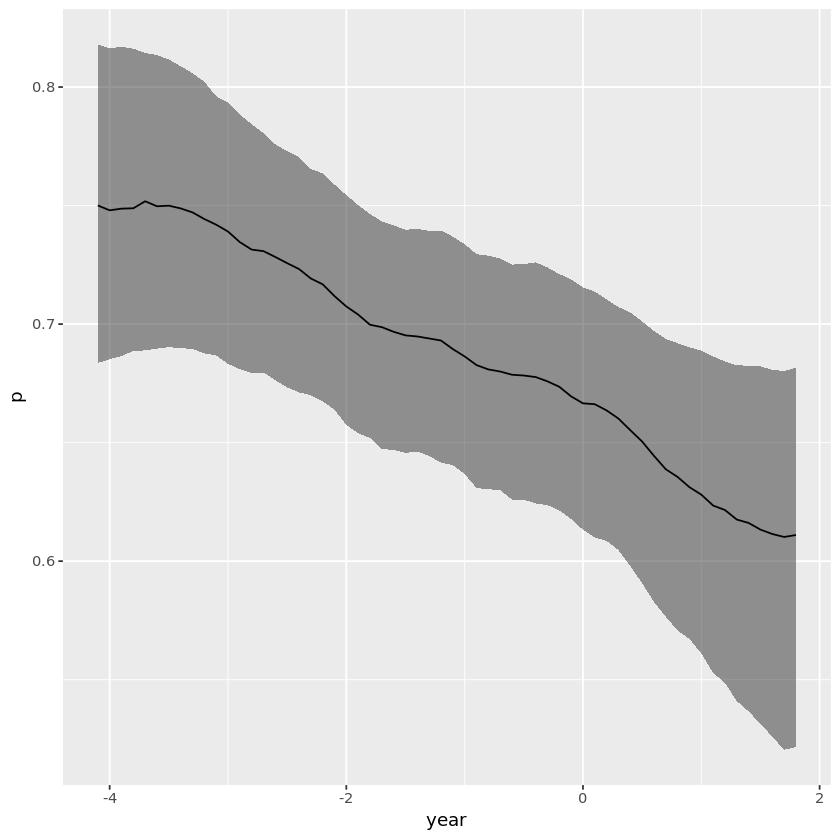

In [13]:
apply(extract(fit_ss, "prob")[[1]], 2, function (x) quantile(x, c(.25, .5, .75))) %>% 
  t() %>% as.data.frame() %>% setNames(c("pmin", "p", "pmax")) %>% 
  mutate(year=stan_data$decade) %>%
  ggplot(aes(x=year, ymin=pmin, y=p, ymax=pmax)) + geom_ribbon(alpha=.5) + geom_line()

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


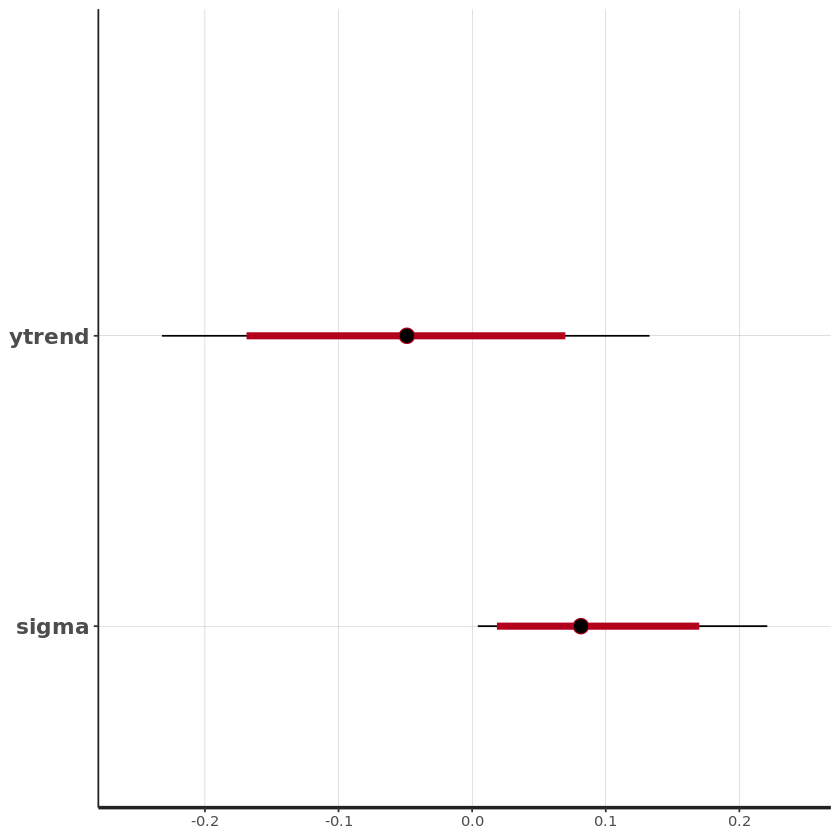

In [14]:
plot(fit_ss, pars=c("ytrend", "sigma"))

[1] 0.162

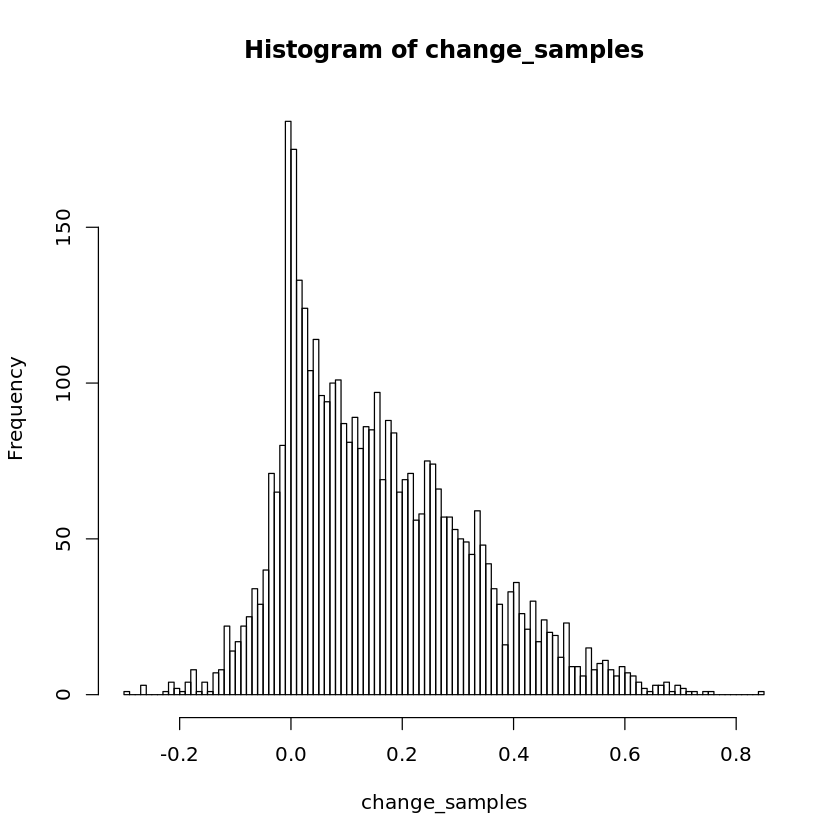

In [16]:
change_samples <- extract(fit_ss, "prob[1]")[[1]] - extract(fit_ss, "prob[60]")[[1]]
hist(change_samples, n=100)
mean(change_samples<0)